# Call Option Benchmarks
Author: JP Melo

### Imports

In [101]:
import torch

DEV = torch.device("cuda")   
torch.set_default_device(DEV)

from derpinns.nn import *
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
from nets import *
from optimizer import *
from functools import wraps
import time, torch
from functools import wraps
import json

DTYPE = torch.float64

In [102]:
def handle_serialization(obj):
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, list):
        return [handle_serialization(item) for item in obj]
    elif isinstance(obj, dict):
        return {k: handle_serialization(v) for k, v in obj.items()}
    elif isinstance(obj, float):
        return float(obj)
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.float64):
        return float(obj)
    else:
        raise TypeError(f"Type {type(obj)} not serializable")

# ───────────────── timing decorator ────────────────────────────────
def timed(fn):
    """Print wall-time of every call to *fn* (CUDA-synchronised)."""
    @wraps(fn)
    def wrapper(self, *args, **kwargs):
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        t0 = time.perf_counter()

        out = fn(self, *args, **kwargs)

        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        dt = (time.perf_counter() - t0) * 1e3
        print(f"[{fn.__name__:<30}] {dt:8.3f} ms")
        return out
    return wrapper
# ───────────────────────────────────────────────────────────────────


class DimlessBS:
    # ─────────────── ctor ──────────────────────────────────────────
    def __init__(self, x, y, mask, n_assets,
                 model, rho, sigma, r,
                 dtype, device):

        self.n_assets = n_assets
        self.sigma, self.r, self.rho = sigma, r, rho
        self.model  = model.to(device, dtype)
        self.y      = y.to(device, dtype)
        self.x      = x.to(device, dtype)
        self.mask   = mask

        self.dtype  = dtype
        self.device = device

    # ─────────────── derivatives ──────────────────────────────────
    @timed
    def compute_derivatives(self, x):
        x = x.requires_grad_(True)
        u = self.model(x)

        g = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_tau = g[:, -1]
        u_x   = g[:, :self.n_assets]

        u_xx = torch.stack([
            torch.autograd.grad(
                u_x[:, j].sum(), x, create_graph=True
            )[0][:, :self.n_assets]
            for j in range(self.n_assets)
        ], dim=1)

        return u, u_tau, u_x, u_xx

    # ─────────────── interior PDE residual (sign fixed) ───────────
    @timed
    def interior_residual(self, u, u_tau, u_x, u_xx):
        diffusion = torch.zeros_like(u_tau)
        drift     = torch.zeros_like(u_tau)

        for i in range(self.n_assets):
            diffusion += 0.5 * self.sigma[i]**2 * u_xx[:, i, i]
            drift     += (self.r - 0.5 * self.sigma[i]**2) * u_x[:, i]
            for j in range(i + 1, self.n_assets):
                diffusion += (self.sigma[i] * self.sigma[j] *
                              self.rho[i, j] * u_xx[:, i, j])

        reaction = self.r * u.squeeze()
        # -------- sign changed here:  -u_tau + diffusion + drift - r u
        return -u_tau + diffusion + drift - reaction

    # ─────────────── top & bottom faces (unchanged) ───────────────
    @timed
    def __top_i_boundary_residual(self, u, u_tau, u_x, u_xx, i):
        drift_sum = (self.r * u_x).sum(-1)

        cross = torch.zeros_like(drift_sum)
        for k in range(self.n_assets):
            for j in range(k + 1, self.n_assets):
                if k != i and j != i:
                    cross += 2 * self.sigma[k] * self.sigma[j] * \
                             self.rho[k, j] * u_xx[:, k, j]

        pure = torch.zeros_like(drift_sum)
        for j in range(self.n_assets):
            if j != i:
                pure += self.sigma[j]**2 * (u_xx[:, j, j] - u_x[:, j])

        return -u_tau + drift_sum + 0.5 * (cross + pure) - self.r * u.squeeze()

    @timed
    def __bottom_i_boundary_residual(self, u, u_tau, u_x, u_xx, i):
        drift_sum = torch.zeros_like(u_tau)
        for j in range(self.n_assets):
            if j != i:
                drift_sum += self.r * u_x[:, j]

        cross = torch.zeros_like(u_tau)
        for k in range(self.n_assets):
            for j in range(k + 1, self.n_assets):
                if k != i and j != i:
                    cross += 2 * self.sigma[k] * self.sigma[j] * \
                             self.rho[k, j] * u_xx[:, k, j]

        pure = torch.zeros_like(u_tau)
        for j in range(self.n_assets):
            if j != i:
                pure += self.sigma[j]**2 * (u_xx[:, j, j] - u_x[:, j])

        return -u_tau + drift_sum + 0.5 * (cross + pure) - self.r * u.squeeze()

    # ─────────────── boundary loss (unchanged) ────────────────────
    @timed
    def boundary_loss(self, u, u_tau, u_x, u_xx):
        losses = torch.zeros(self.n_assets * 2, dtype=self.dtype, device=self.device)

        for i in range(self.n_assets):
            top_mask    = self.mask[:, 2 + 2 * i].bool()
            bottom_mask = self.mask[:, 3 + 2 * i].bool()

            if bottom_mask.any():
                br = self.__bottom_i_boundary_residual(
                        u[bottom_mask], u_tau[bottom_mask],
                        u_x[bottom_mask], u_xx[bottom_mask], i)
                losses[2 * i] = (br ** 2).mean()

            if top_mask.any():
                tr = self.__top_i_boundary_residual(
                        u[top_mask], u_tau[top_mask],
                        u_x[top_mask], u_xx[top_mask], i)
                losses[2 * i + 1] = (tr ** 2).mean()

        return losses

    # ─────────────── initial condition residual ───────────────────
    @timed
    def initial_residual(self, u, y):
        return u - y

    # ─────────────── overall loss ---------------------------------
    @timed
    def compute_losses(self):
        u, u_tau, u_x, u_xx = self.compute_derivatives(self.x)

        # interior
        interior_mask = self.mask[:, 0].bool()
        if interior_mask.any():
            interior = (self.interior_residual(
                            u[interior_mask], u_tau[interior_mask],
                            u_x[interior_mask], u_xx[interior_mask]) ** 2).mean()
        else:
            interior = torch.tensor(0., dtype=self.dtype, device=self.device)

        # initial
        init_mask = self.mask[:, 1].bool()
        if init_mask.any():
            initial = (self.initial_residual(
                           u[init_mask], self.y[init_mask]) ** 2).mean()
        else:
            initial = torch.tensor(0., dtype=self.dtype, device=self.device)

        # boundaries
        boundary = self.boundary_loss(u, u_tau, u_x, u_xx).sum()

        return interior, boundary, initial

    # ─────────────── callable -------------------------------------
    @timed
    def __call__(self, *_, **__):
        interior, boundary, initial = self.compute_losses()
        total = interior + boundary + initial
        print(f"Interior {interior.item():.4e} | "
              f"Boundary {boundary.item():.4e} | "
              f"Initial {initial.item():.4e} | "
              f"Total {total.item():.4e}")
        return total


In [103]:
import time, torch
from functools import wraps

def timed(fn):
    @wraps(fn)
    def wrapper(self, *a, **kw):
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        t0 = time.perf_counter()
        out = fn(self, *a, **kw)
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
        print(f"[{fn.__name__:<30}] {(time.perf_counter()-t0)*1e3:8.3f} ms")
        return out
    return wrapper

class DimlessBS:
    # ---------------------------------------------------------------
    def __init__(self, x, y, mask, n_assets,
                 model, rho, sigma, r,
                 dtype, device):

        self.n_assets = n_assets

        # ── convert NumPy → torch tensors here ───────────────────
        self.sigma = torch.as_tensor(sigma, dtype=dtype, device=device)  # (d,)
        self.rho   = torch.as_tensor(rho,   dtype=dtype, device=device)  # (d,d)
        self.r     = torch.tensor(r,        dtype=dtype, device=device)

        self.model = model.to(device, dtype)
        self.x     = x.to(device, dtype)
        self.y     = y.to(device, dtype)
        self.mask  = mask

        self.dtype  = dtype
        self.device = device

    # ---------------------------------------------------------------
    def compute_derivatives(self, x):
        x = x.requires_grad_(True)
        u = self.model(x)

        g = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_tau = g[:, -1]
        u_x   = g[:, :self.n_assets]

        u_xx = torch.stack([
            torch.autograd.grad(
                u_x[:, j].sum(), x, create_graph=True
            )[0][:, :self.n_assets]
            for j in range(self.n_assets)
        ], dim=1)
        return u, u_tau, u_x, u_xx

    # ---------------------------------------------------------------
    # ----------  interior residual  --------------------------------
    def interior_residual(self, u, u_tau, u_x, u_xx):
        """  u_tau  -  RHS  of the scaled PDE  """
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1)                                   # (B,)

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            for j in range(i + 1, self.n_assets):
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        # the PDE wants ½∑_{i≠j} … , our loop counts each pair once
        cross = 0.5 * cross

        drift = self.r * u_x.sum(-1)                          # (B,)
        reaction = -self.r * u.squeeze(-1)                    # (B,)

        return u_tau - (diag + cross + drift + reaction)

    # ---------------------------------------------------------------
    def __top_i_boundary_residual(self, u, u_tau, u_x, u_xx, k):
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1) - 0.5 * self.sigma[k]**2 * (u_xx[:, k, k] - u_x[:, k])

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            if i == k: continue
            for j in range(i + 1, self.n_assets):
                if j == k: continue
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        cross *= 0.5

        drift = self.r * u_x.sum(-1)                          # all i
        reaction = -self.r * u.squeeze(-1)

        return u_tau - (diag + cross + drift + reaction)

    
    def __bottom_i_boundary_residual(self, u, u_tau, u_x, u_xx, k):
        diag = 0.5 * (self.sigma ** 2) * (u_xx.diagonal(dim1=1, dim2=2) - u_x)
        diag = diag.sum(-1) - 0.5 * self.sigma[k]**2 * (u_xx[:, k, k] - u_x[:, k])

        cross = torch.zeros_like(u_tau)
        for i in range(self.n_assets):
            if i == k: continue
            for j in range(i + 1, self.n_assets):
                if j == k: continue
                cross += (self.sigma[i] * self.sigma[j] *
                          self.rho[i, j] * u_xx[:, i, j])
        cross *= 0.5

        drift = self.r * u_x.sum(-1) - self.r * u_x[:, k]     # exclude k
        reaction = -self.r * u.squeeze(-1)

        return u_tau - (diag + cross + drift + reaction)

    # ---------------------------------------------------------------
    def boundary_loss(self, u, u_tau, u_x, u_xx):
        losses = torch.zeros(self.n_assets * 2,
                             dtype=self.dtype, device=self.device)

        for i in range(self.n_assets):
            top_mask    = self.mask[:, 2 + 2*i].bool()
            bottom_mask = self.mask[:, 3 + 2*i].bool()

            if bottom_mask.any():
                br = self.__bottom_i_boundary_residual(
                        u[bottom_mask], u_tau[bottom_mask],
                        u_x[bottom_mask], u_xx[bottom_mask], i)
                losses[2*i] = (br ** 2).mean()

            if top_mask.any():
                tr = self.__top_i_boundary_residual(
                        u[top_mask], u_tau[top_mask],
                        u_x[top_mask], u_xx[top_mask], i)
                losses[2*i + 1] = (tr ** 2).mean()
        return losses

    # ---------------------------------------------------------------
    def initial_residual(self, u, y):
        return u - y

    # ---------------------------------------------------------------
    def compute_losses(self):
        u, u_tau, u_x, u_xx = self.compute_derivatives(self.x)

        # interior
        interior_mask = self.mask[:, 0].bool()
        if interior_mask.any():
            interior = (self.interior_residual(
                            u[interior_mask], u_tau[interior_mask],
                            u_x[interior_mask], u_xx[interior_mask]) ** 2).mean()
        else:
            interior = torch.tensor(0., dtype=self.dtype, device=self.device)

        # initial
        init_mask = self.mask[:, 1].bool()
        if init_mask.any():
            initial = (self.initial_residual(
                           u[init_mask], self.y[init_mask]) ** 2).mean()
        else:
            initial = torch.tensor(0., dtype=self.dtype, device=self.device)

        # boundaries
        boundary = self.boundary_loss(u, u_tau, u_x, u_xx).sum()

        return interior, boundary, initial

   
    def __call__(self, *_, **__):
        interior, boundary, initial = self.compute_losses()
        total = interior + boundary + initial
        print(f"Interior {interior.item():.4e} | "
              f"Boundary {boundary.item():.4e} | "
              f"Initial {initial.item():.4e} | "
              f"Total {total.item():.4e}")
        return total


In [104]:
assets = [2,3,5,7]
sampler = "Sobol"     
                        

In [105]:
# load json if it exists, else create it
try:
    with open("bench.json", "r") as f:
        bench = json.load(f)
except FileNotFoundError:
    bench = {}
    with open("bench.json", "w") as f:
        json.dump(bench, f)

In [ ]:
for n in assets:
    boundary_samples = 500
    interior_samples = boundary_samples*n*2
    initial_samples = boundary_samples*n*2           

    params = OptionParameters(
                n_assets=n,
                tau=1.0,
                sigma=np.array([0.2] * n),
                rho=np.eye(n) + 0.25 * (np.ones((n, n)) - np.eye(n)),
                r=0.05,
                strike=100,
                payoff=payoff
            )
    dataset = SampledDataset(params, interior_samples, initial_samples, boundary_samples, sampler, DTYPE, DEV, seed=0)

    X = dataset.x
    Y = dataset.y.squeeze()
    mask = dataset.mask

    model = MLP(in_dim=n+1, hidden_layers=[10, 10, 10], out_dim=1).to(DEV)
    for p in model.parameters():
        if p.dim()>1: nn.init.xavier_uniform_(p)

    opt = SSBroyden(model.parameters(), max_iter=5_000)
    obj = DimlessBS(
            x        = X,
            y        = Y,
            mask     = mask,
            n_assets = n,          # int
            model    = model,
            rho      = params.rho,
            sigma    = params.sigma,
            r        = params.r,
            dtype    = torch.float64,
            device   = "cuda"
    )

    losses = []
    def closure(*args, **kwargs):
        opt.zero_grad()
        loss = obj()
        loss.backward()
        losses.append(loss.item())
        print(f"Step {len(losses)}")
        return loss
    print(f"Training model with {n} assets")

    start_time = time.time()
    opt.step(closure)
    end_time = time.time()
    print("training finished")

    bench[f"model_10x2_{n}"] = {
        "losses": losses,
        "time": end_time - start_time,
    }
    with open("bench.json", "w") as f:
        json.dump(bench, f, default=handle_serialization, indent=4)
    torch.save(model.state_dict(), f"model_10x2_{n}.pt")

Training model with 2 assets
Interior 3.1023e-03 | Boundary 2.0325e-02 | Initial 4.1770e+00 | Total 4.2004e+00
Step 1
Interior 2.0964e-03 | Boundary 1.5215e-02 | Initial 3.9639e+00 | Total 3.9812e+00
Step 2
Interior 2.0964e-03 | Boundary 1.5215e-02 | Initial 3.9639e+00 | Total 3.9812e+00
Step 3
Interior 1.6435e-03 | Boundary 1.2359e-02 | Initial 3.8736e+00 | Total 3.8876e+00
Step 4
Interior 1.4067e-03 | Boundary 8.3550e-03 | Initial 3.5598e+00 | Total 3.5695e+00
Step 5
Interior 1.4067e-03 | Boundary 8.3550e-03 | Initial 3.5598e+00 | Total 3.5695e+00
Step 6
Interior 2.1692e-03 | Boundary 1.1794e-02 | Initial 3.1376e+00 | Total 3.1516e+00
Step 7
Interior 2.1490e-02 | Boundary 1.5096e-01 | Initial 3.8545e+00 | Total 4.0269e+00
Step 8
Interior 7.1769e-03 | Boundary 4.5614e-02 | Initial 2.0625e+00 | Total 2.1152e+00
Step 9
Interior 7.1769e-03 | Boundary 4.5614e-02 | Initial 2.0625e+00 | Total 2.1152e+00
Step 10
Interior 2.0356e-02 | Boundary 1.2633e-01 | Initial 1.8143e+00 | Total 1.9610e+0

In [ ]:
s_min = np.exp(params.x_min)*params.strike
s_max = np.exp(params.x_max)*params.strike

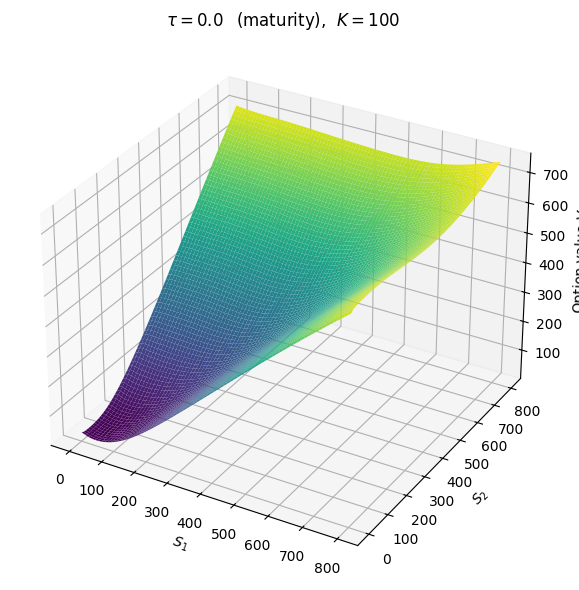

In [ ]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # noqa: F401

def plot_two_stock_surface_log(
        model,
        strike: float,
        n_asset: int = 2,
        s_min: float = 1e-3,      # avoid log(0)
        s_max: float = 2.0,       # multiple of K shown on the axes
        n_steps: int = 60,
        tau_val: float = 0.0):
    """
    Render V(S₁,S₂,τ=tau_val) when the network expects log-inputs.

    Parameters
    ----------
    model               : trained network taking [log(S₁/-), log(S₂/-), τ] → V
    strike              : strike K used in training
    s_min, s_max        : lower / upper bound of the price range as multiples of K
    n_steps             : grid resolution per axis
    tau_val             : τ value to feed to the net (0 = maturity in your set-up)
    """
    model.eval()
    dtype  = next(model.parameters()).dtype    # match net’s precision (float64)
    device = next(model.parameters()).device   # and device

    # ---------- build a price grid ----------
    prices = torch.linspace(s_min, s_max,
                            n_steps, dtype=dtype, device=device)
    S1, S2 = torch.meshgrid(prices, prices, indexing="ij")

    # ---------- convert to the network’s input space ----------
    X1 = torch.log(S1 / strike)
    X2 = torch.log(S2 / strike)
    Xn = torch.zeros_like(X1)  
    
    tau  = torch.full_like(S1, tau_val)        # constant τ plane
    if n_asset > 2:
        n = n_asset - 2
    else:
        n = 0
    X_in = torch.stack([X1.reshape(-1),
                        X2.reshape(-1),
                        *[Xn.reshape(-1)]*n,  
                        tau.reshape(-1)], dim=1)

    # ---------- forward pass ----------
    with torch.no_grad():
        V = model(X_in).view(n_steps, n_steps).cpu().numpy()* strike  

    # ---------- plot ----------
    S1_np, S2_np = S1.cpu().numpy(), S2.cpu().numpy()

    fig = plt.figure(figsize=(8, 6))
    ax  = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S1_np, S2_np, V,
                    rstride=1, cstride=1,
                    linewidth=0, antialiased=True, cmap="viridis",)

    ax.set_xlabel(r" $S_1$")
    ax.set_ylabel(r"$S_2$")
    ax.set_zlabel(r"Option value $V$")
    ax.set_title(rf"$\tau={tau_val}\,$  (maturity),  $K={strike}$")
    plt.tight_layout()
    plt.show()

# assuming you have already loaded the trained weights:
# model.load_state_dict(torch.load("swaption.pt"))

plot_two_stock_surface_log(
    model,
    strike=params.strike,   # 100 in your training block
    n_asset=params.n_assets,  # 2 in your training block
    s_min=s_min,
    s_max=s_max,              # shows 0 → 2 × K on each axis
    n_steps=80,
    tau_val=0.0             # τ = 0 corresponds to today / maturity
)
